# In this ipynb file, we will vary epsilon and minpts and compare the results with the original file's results

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import Counter
sns.set()

In [2]:
# import the whole training dataset
df = pd.read_csv('miami-housing.csv')
# print the dataset 
df.head()

,LATITUDE,LONGITUDE,PARCELNO,SALE_PRC,LND_SQFOOT,TOT_LVG_AREA,SPEC_FEAT_VAL,RAIL_DIST,OCEAN_DIST,WATER_DIST,CNTR_DIST,SUBCNTR_DI,HWY_DIST,age,avno60plus,month_sold,structure_quality
0,25.891031,-80.160561,622280070620,440000.0,9375,1753,0,2815.9,12811.4,347.6,42815.3,37742.2,15954.9,67,0,8,4
1,25.891324,-80.153968,622280100460,349000.0,9375,1715,0,4359.1,10648.4,337.8,43504.9,37340.5,18125.0,63,0,9,4
2,25.891334,-80.153740,622280100470,800000.0,9375,2276,49206,4412.9,10574.1,297.1,43530.4,37328.7,18200.5,61,0,2,4
3,25.891765,-80.152657,622280100530,988000.0,12450,2058,10033,4585.0,10156.5,0.0,43797.5,37423.2,18514.4,63,0,9,4
4,25.891825,-80.154639,622280100200,755000.0,12800,1684,16681,4063.4,10836.8,326.6,43599.7,37550.8,17903.4,42,0,7,4


In [3]:
# get columsn latitude and longitude
x = df[['LATITUDE','LONGITUDE']] 
# returns a numpy array
x.values
# do min_max normalization on latitude and longitude
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
# put the numpy array x_scaled back into a DataFrame
x_df = pd.DataFrame(x_scaled)
x_df.head()

,0,1
0,0.845660,0.903382
1,0.846203,0.918989
2,0.846222,0.919529
3,0.847019,0.922091
4,0.847130,0.917398


In [4]:
# To determine optimal epsilon parameter, compute the k-NearestNeighbour (kNN) distances (average distance 
# of every data point to its k-nearest neighbors) of an input dataset using the k-nearest neighbor method 
# (unsupervised nearest neighbors learning).
# n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros) 
nbrs = NearestNeighbors(n_neighbors=5).fit(x_df)
# Find the k-neighbors of a point
neigh_dist, neigh_ind = nbrs.kneighbors(x_df)
# sort the neighbor distances (lengths to points) in ascending order
# axis = 0 represents sort along first axis i.e. sort along row
sort_neigh_dist = np.sort(neigh_dist, axis=0)

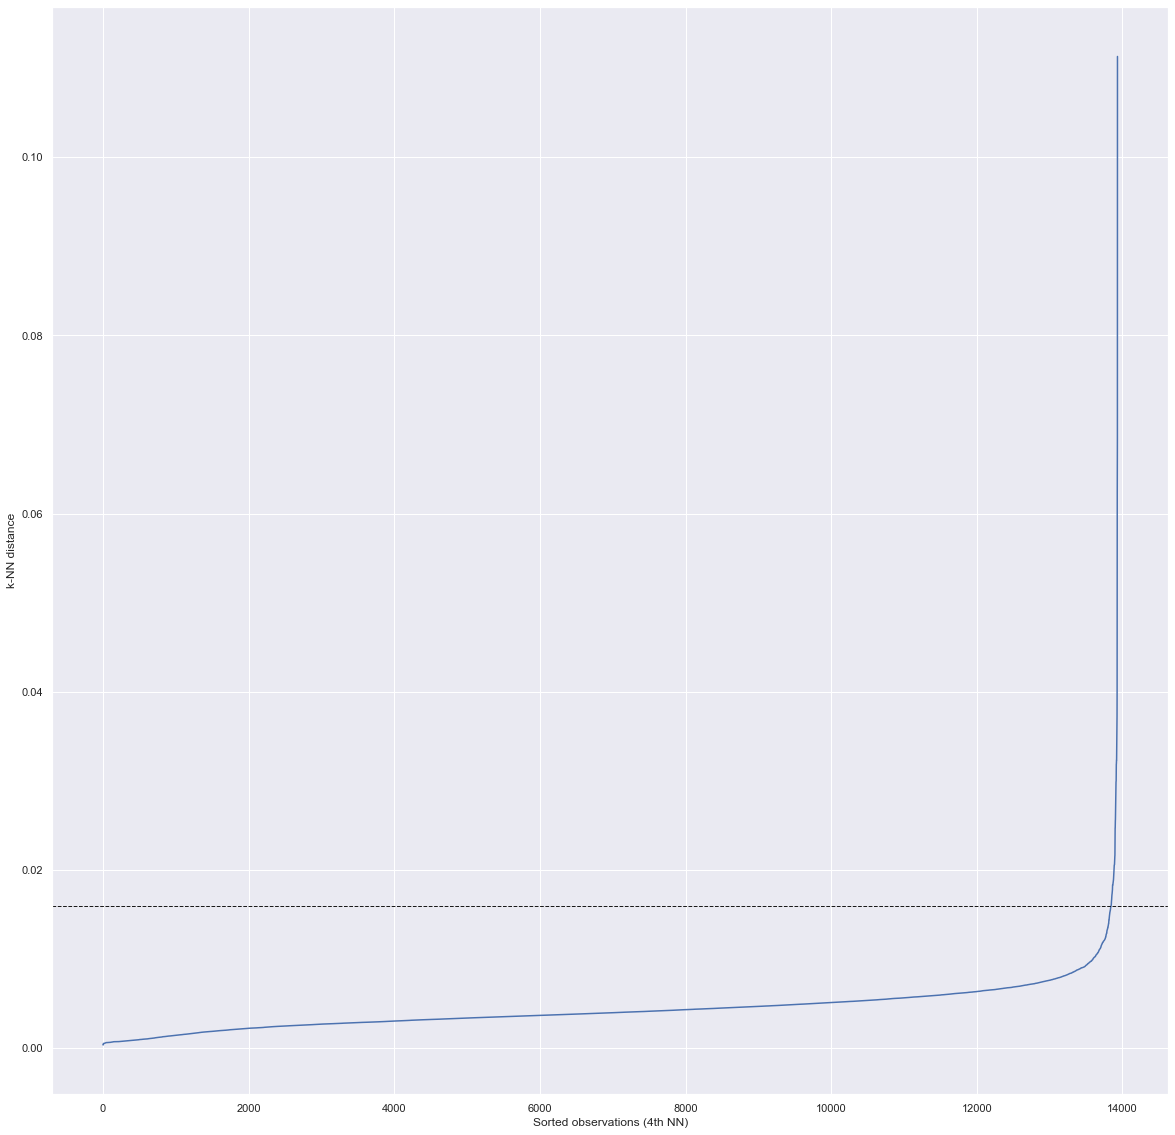

In [5]:
#plot the kNN graph to get epsilon
k_dist = sort_neigh_dist[:, 4]
plt.figure(figsize=(20,20))
plt.plot(k_dist)
plt.axhline(y=0.016, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Sorted observations (4th NN)")
plt.show()

In [6]:
# In the k-NN distance plot, you should look for the “knee” of the curve to find the optimal value of epsilon
# In the plot above, the knee occurs at approximately 0.016, i.e. the points below 0.016 belong to a cluster 
# and points above 0.016 are noise or outliers (noise points will have higher kNN distance).
# A general rule of thumb when selecting minpts for dbscan is 2 * number of features
# Since we are using latitude and longitude, our minpts = 4

In [8]:
# do DBSCAN on x_df - normalized latitude and longitude
clusters = DBSCAN(eps=0.016, min_samples=5).fit(x_df)

In [9]:
# Cluster labels for each point in the dataset given to fit(). Noisy samples are given the label -1.
# put it inside x_df 
x_df['clusters'] = clusters.labels_

In [10]:
set(clusters.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [11]:
# count the number of points in each cluster
Counter(clusters.labels_)

Counter({0: 13085,
         -1: 58,
         1: 10,
         2: 22,
         3: 8,
         8: 7,
         4: 102,
         5: 9,
         6: 77,
         7: 16,
         9: 14,
         10: 13,
         11: 17,
         12: 35,
         13: 273,
         14: 12,
         15: 27,
         16: 7,
         17: 6,
         20: 5,
         18: 121,
         19: 8})

In [12]:
# rename 0 to latitude and 1 to longitude
x_df.columns = ['latitude', 'longitude', 'clusters']

In [13]:
x_df.head()

,latitude,longitude,clusters
0,0.845660,0.903382,0
1,0.846203,0.918989,0
2,0.846222,0.919529,0
3,0.847019,0.922091,0
4,0.847130,0.917398,0


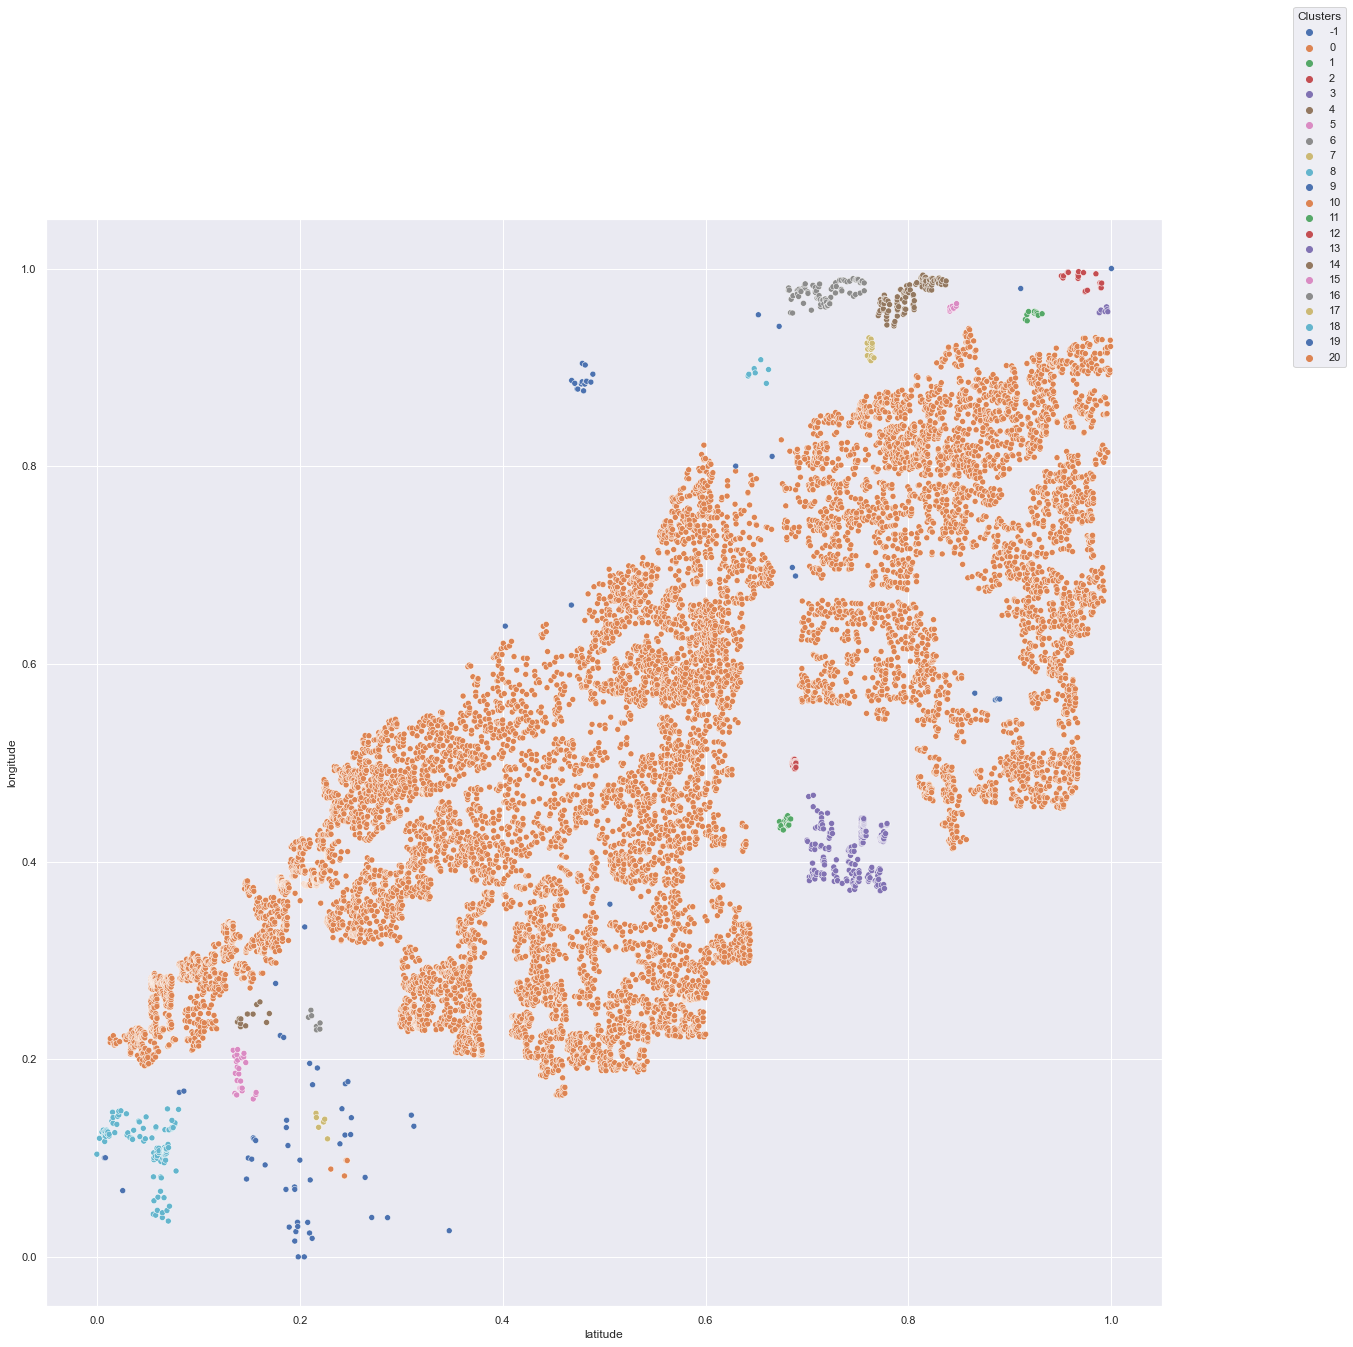

In [16]:
# plot a scatterplot based on the dbscan and show the points with their associated clusters
plt.figure(figsize=(20,20))
p = sns.scatterplot(data=x_df, x="latitude", y="longitude", hue=clusters.labels_, legend="full", palette="deep")
sns.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
plt.show()

In [14]:
# put the sale price column from the original column into x_df
x_df['sale_prc'] = df['SALE_PRC']

In [15]:
x_df.head()

,latitude,longitude,clusters,sale_prc
0,0.845660,0.903382,0,440000.0
1,0.846203,0.918989,0,349000.0
2,0.846222,0.919529,0,800000.0
3,0.847019,0.922091,0,988000.0
4,0.847130,0.917398,0,755000.0


<AxesSubplot:xlabel='clusters', ylabel='sale_prc'>

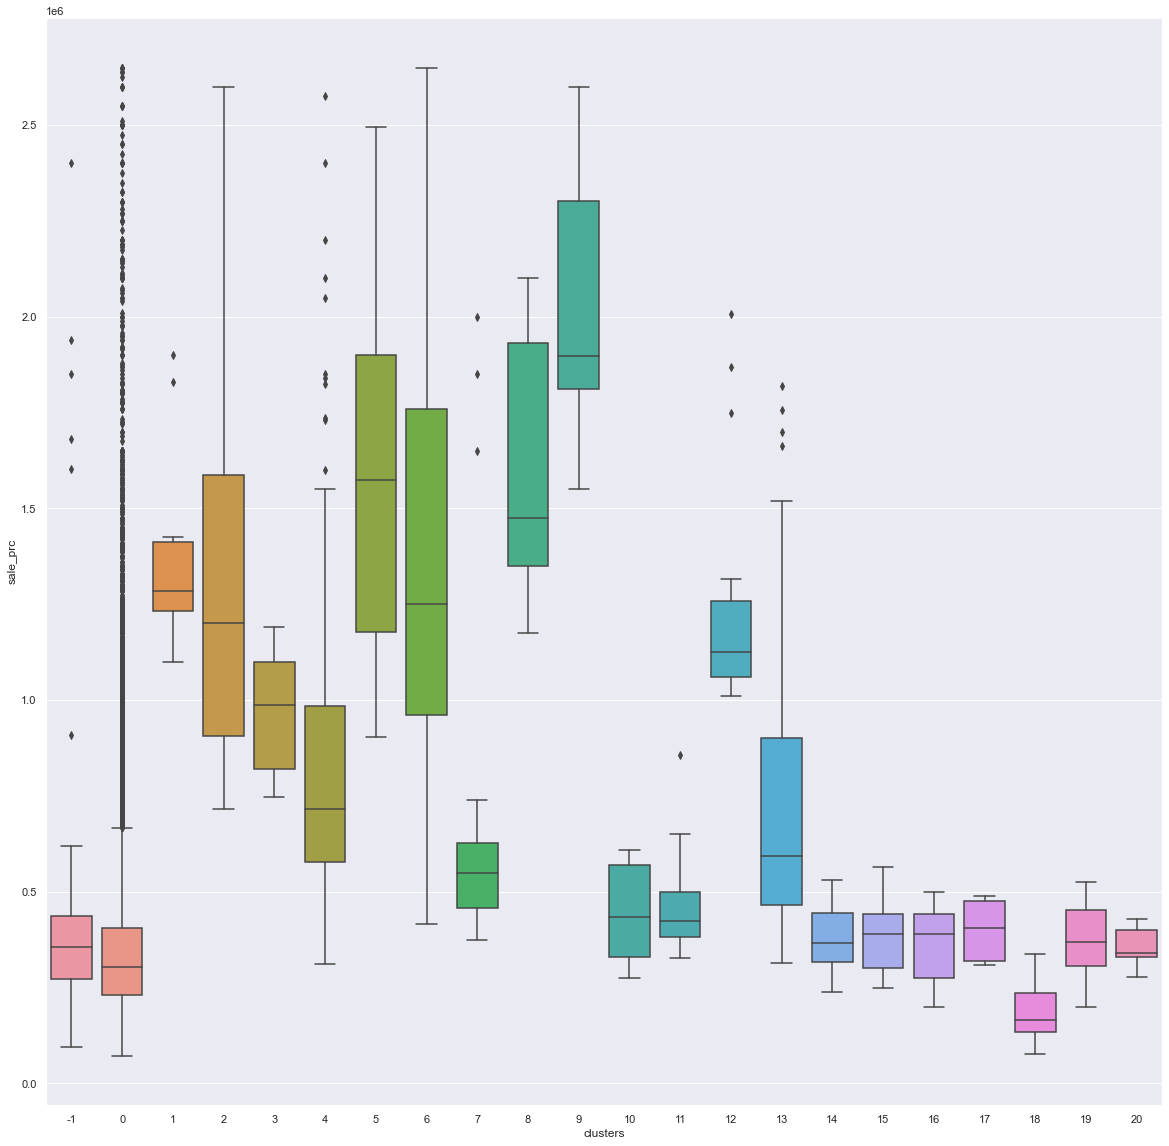

In [17]:
# show the distribution of the clusters with respect to the saleprice
plt.figure(figsize=(20,20))
sns.boxplot(data=x_df, x='clusters', y='sale_prc')

In [ ]:
# At first glance, the most obvious difference when increasing minpts from 4 to 5 is that the 
# number of clusters have decreased from 24 to 22.
# The next difference is that the number of outliers has increased from 48 to 58.